In [1]:
import os
import random
import numpy as np
from io import BytesIO

# Plotting and dealing with images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf

# Interactive widgets
from ipywidgets import widgets

2024-11-11 19:17:31.400423: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
base_dir = 'rps'

rock_dir = os.path.join(base_dir,'rock')
paper_dir = os.path.join(base_dir,'paper')
scissors_dir = os.path.join(base_dir,'scissors')

rock_files = os.listdir(rock_dir)
paper_files = os.listdir(paper_dir)
scissors_files = os.listdir(scissors_dir)

print("Contents of base_dir:",base_dir)
print("Contents of rock_dir:",rock_dir)
print("Contents of paper_dir:",paper_dir)
print("Contents of scissors_dir:",scissors_dir)
print()

Contents of base_dir: rps
Contents of rock_dir: rps/rock
Contents of paper_dir: rps/paper
Contents of scissors_dir: rps/scissors



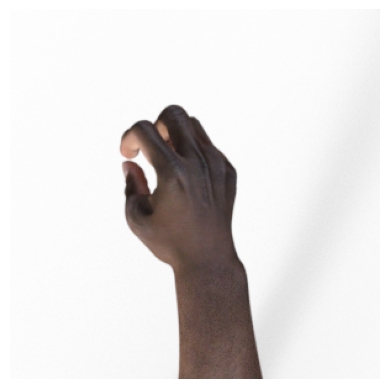

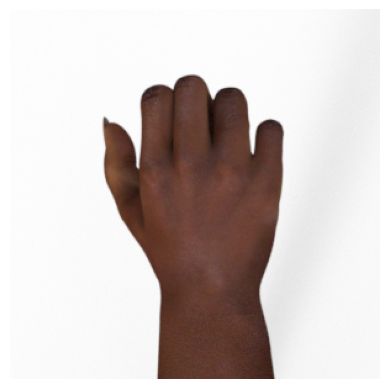

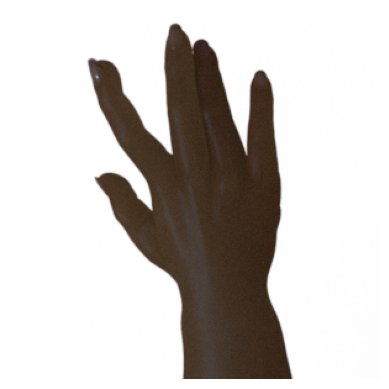

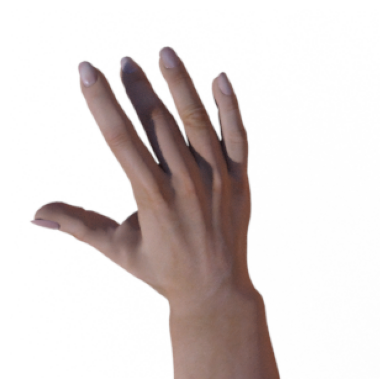

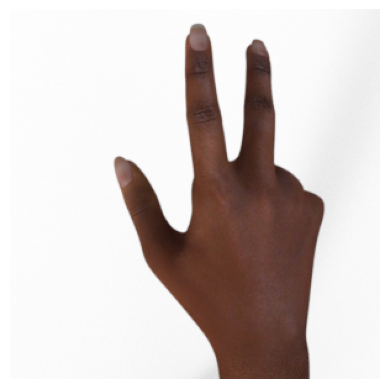

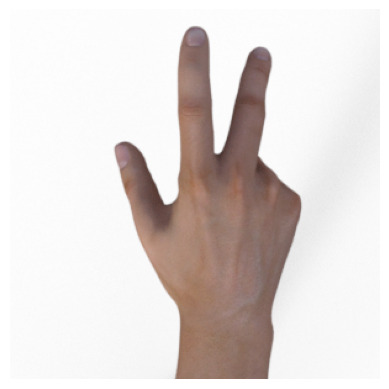

In [5]:
next_rock = [os.path.join(rock_dir, fname)
             for fname in random.sample(rock_files, k=2)]
next_paper = [os.path.join(paper_dir, fname)
              for fname in random.sample(paper_files, k=2)]
next_scissors = [os.path.join(scissors_dir, fname)
                 for fname in random.sample(scissors_files, k=2)]

for i, img_path in enumerate(next_rock+next_paper+next_scissors):
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('Off')
    plt.show()

In [6]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(150,150,3)),
    tf.keras.layers.Rescaling(.1/255),
    
    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation = 'relu'),
    tf.keras.layers.Dense(3,activation = 'sigmoid')

])

2024-11-11 19:28:12.509983: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       7

In [18]:
Training_dir = 'rps'
Validation_dir = 'rps-test-set'

training_dataset = tf.keras.utils.image_dataset_from_directory(
    Training_dir,
    image_size = (150,150),
    batch_size = 32,
    label_mode = 'categorical'
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    Validation_dir,
    image_size = (150,150),
    batch_size = 32,
    label_mode = 'categorical'
)

training_dataset_final = training_dataset.cache().shuffle(buffer_size = 1000).prefetch(buffer_size = tf.data.AUTOTUNE)
validation_dataset_final = validation_dataset.cache().shuffle(buffer_size = 1000).prefetch(buffer_size = tf.data.AUTOTUNE)
                                    

Found 2520 files belonging to 3 classes.
Found 372 files belonging to 3 classes.


In [20]:
data_augmentation = tf.keras.Sequential([
    tf.keras.Input(shape = (150,150,3)),
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.4,fill_mode = 'nearest'),
    tf.keras.layers.RandomTranslation(0.2,0.2,fill_mode = 'nearest'),
    tf.keras.layers.RandomZoom(0.2,fill_mode = 'nearest'),
    tf.keras.layers.RandomContrast(0.4)
])

augmented_model = tf.keras.Sequential([
    data_augmentation,
    model
])

In [21]:
augmented_model.compile(optimizer = 'rmsprop',
                        loss = 'categorical_crossentropy',
                        metrics = ['accuracy']
                        )

In [23]:
history = augmented_model.fit(
    training_dataset_final,
    epochs = 25,
    validation_data = validation_dataset_final,
    verbose = 1
)

Epoch 1/25
79/79 [==============================] - ETA: 0s - loss: 1.1005 - accuracy: 0.3440

2024-11-11 20:33:43.437708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [372]
	 [[{{node Placeholder/_0}}]]
2024-11-11 20:33:43.446195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [372]
	 [[{{node Placeholder/_0}}]]


79/79 [==============================] - 394s 5s/step - loss: 1.1005 - accuracy: 0.3440 - val_loss: 1.1005 - val_accuracy: 0.3333
Epoch 2/25
79/79 [==============================] - 382s 5s/step - loss: 1.0996 - accuracy: 0.3421 - val_loss: 1.0998 - val_accuracy: 0.3333
Epoch 3/25
79/79 [==============================] - 321s 4s/step - loss: 1.0982 - accuracy: 0.3409 - val_loss: 1.1026 - val_accuracy: 0.3468
Epoch 4/25
79/79 [==============================] - 227s 3s/step - loss: 1.0958 - accuracy: 0.3512 - val_loss: 1.0875 - val_accuracy: 0.3360
Epoch 5/25
79/79 [==============================] - 207s 3s/step - loss: 1.0827 - accuracy: 0.3988 - val_loss: 1.0524 - val_accuracy: 0.4194
Epoch 6/25
79/79 [==============================] - 206s 3s/step - loss: 1.0521 - accuracy: 0.4353 - val_loss: 0.9565 - val_accuracy: 0.6290
Epoch 7/25
79/79 [==============================] - 205s 3s/step - loss: 0.9499 - accuracy: 0.5290 - val_loss: 0.6548 - val_accuracy: 0.7554
Epoch 8/25
79/79 [======

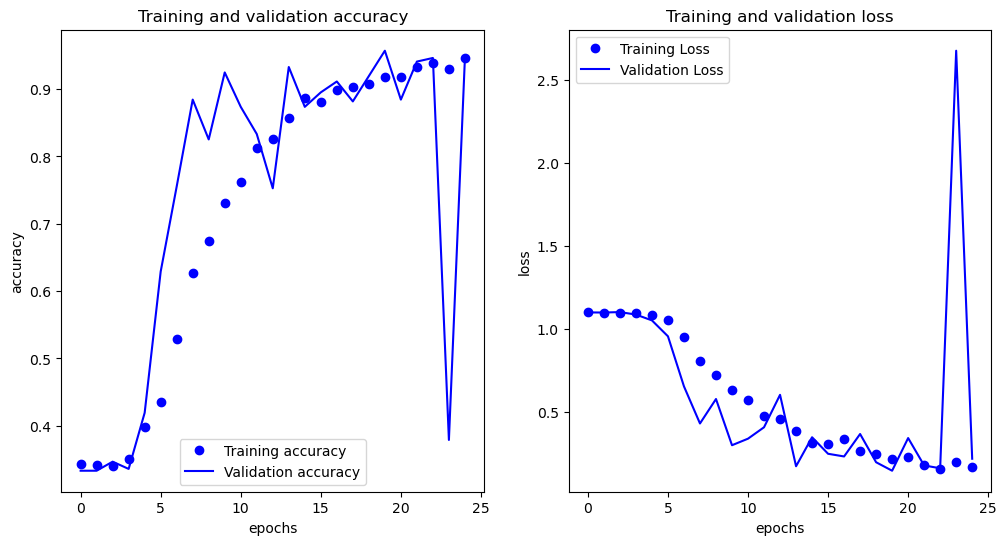

In [24]:
def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1,2, figsize=(12, 6))
  ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
  ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss, 'bo', label='Training Loss')
  ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

  plt.show()

plot_loss_acc(history)

In [25]:
# Create the widget and take care of the display
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

def file_predict(filename, file, out):
    """ A function for creating the prediction and printing the output."""
    image = tf.keras.utils.load_img(file, target_size=(150, 150))
    image = tf.keras.utils.img_to_array(image)
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image, verbose=0)[0]

    with out:

        print(f'\nmodel output: {prediction}')
        
        prediction_index = np.argmax(prediction)
        
        classes = ["paper", "rock", "scissors"]
        
        predicted_class = classes[prediction_index]
        
        print(f'{filename} is {predicted_class}')


def on_upload_change(change):
    """ A function for geting files from the widget and running the prediction."""
    # Get the newly uploaded file(s)
    
    items = change.new
    for item in items: # Loop if there is more than one file uploaded  
        file_jpgdata = BytesIO(item.content)
        file_predict(item.name, file_jpgdata, out)


uploader.observe(on_upload_change, names='value')

FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Output()